In [1]:
## Figure 1 - Performance Evaluation of Different Weight Functions on Network Inversion with Simulations

import os
import sys
import numpy as np
from matplotlib import pyplot as plt, ticker
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes
import pysar.simulation as psim
from pysar.simulation.plot import *
from pysar.utils import ptime, readfile, writefile, utils as ut, network as pnet, plot as pp
from pysar.objects import timeseries, ifgramStack, sensor
import pysar.ifgram_inversion as ifginv

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/sim4weightFuncs')
os.chdir(work_dir)
print('Go to directory: '+work_dir)
sensorName = sensor.project_name2sensor_name(os.path.join(work_dir, 'AlcedoSenDT128'))[0]

weight_functions = ['Uniform', 'Coherence', 'Variance inv', 'Fisher info']

# Time-series Setup
ts_obj = timeseries(os.path.join(work_dir, 'AlcedoSenDT128/timeseries.h5'))
ts_obj.open()
ts_obj.save2bl_list_file(out_file='bl_list.txt')

tbase = np.array(ts_obj.tbase)
tbase_diff = np.diff(np.array(tbase, dtype=np.float32) / 365.25).reshape(-1, 1)
ts_sim = psim.sim_variable_timeseries(tbase, display=False)

date_list = ts_obj.dateList
dates, datevector = ptime.date_list2vector(date_list)

inc_angle = ut.incidence_angle(ts_obj.metadata, dimension=0, print_msg=False)
phase2range = -1*float(ts_obj.metadata['WAVELENGTH'])/(4.*np.pi)

# Network Setup
num_conn = 10
date12_list = pnet.select_pairs_sequential(date_list, num_connection=num_conn, date12_format='YYYYMMDD_YYYYMMDD')
stack_obj = ifgramStack(os.path.join(work_dir, 'AlcedoSenDT128/ifgramStack.h5'))
A, B = stack_obj.get_design_matrix4timeseries_estimation(date12_list=date12_list)
print('number of ifgrams: {}'.format(len(date12_list)))

## Decorrelation Noise Setup
coh_resid, decor_time = 0.0, 200  # 0.0, 50; 0.1, 50; 0.0, 200; 0.2, 200; 0.4, 200
num_sample = 10000
L_max = 50
out_file = 'rmsVT{:.0f}R{:.1f}L{:d}'.format(decor_time, coh_resid, L_max)
print('output file base: '+out_file)
print('Done.')

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/sim4weightFuncs
open timeseries file: timeseries.h5
write baseline list info to file: bl_list.txt
number of ifgrams: 925
output file base: rmsVT200R0.0L50
Done.


In [43]:
## Run Demo Simulation
L = 3 * 9
ifgram_est, coh_est, ifg_sim, coh_sim = psim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                                                 L=L, num_sample=num_sample,
                                                                 baseline_file='bl_list.txt',
                                                                 sensor_name=sensorName,
                                                                 inc_angle=inc_angle)
ifg_sim = ut.wrap(ifg_sim)
ifg_est = ut.wrap(ifgram_est[:,0])
print('Done.')

Done.


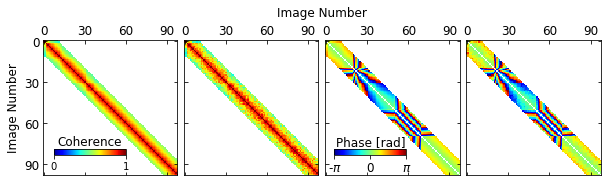

In [58]:
## Figure 1 (a-d) - Simulated coherence and coherence estimation / Noise-free and noisy phase
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=[10, 2.5], sharey=True)

im1 = axs[0].imshow(pnet.coherence_matrix(date12_list, coh_sim, diag_value=1.), vmin=0, vmax=1, cmap='jet')
im1 = axs[1].imshow(pnet.coherence_matrix(date12_list, coh_est, diag_value=1.), vmin=0, vmax=1, cmap='jet')
im2 = axs[2].imshow(pnet.coherence_matrix(date12_list, ifg_sim), vmin=-np.pi, vmax=np.pi, cmap='jet')
im2 = axs[3].imshow(pnet.coherence_matrix(date12_list, ifg_est), vmin=-np.pi, vmax=np.pi, cmap='jet')
# axis format
for ax in axs:
    ax.xaxis.tick_top()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(30))
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
axs[0].set_ylabel('Image Number', fontsize=font_size)
pp.set_shared_xlabel(axs, 'Image Number', labelpad=0.2, font_size=12, position='top')

fig.subplots_adjust(wspace=0.05)
# colorbars
cax = fig.add_axes([0.14, 0.24, 0.1, 0.03])
cbar = plt.colorbar(im1, cax=cax, ticks=[0, 1], orientation='horizontal')
cbar.set_label('Coherence', fontsize=font_size)
cbar.ax.xaxis.set_label_position('top') 

cax = fig.add_axes([0.53, 0.24, 0.1, 0.03])
cbar = plt.colorbar(im2, cax=cax, ticks=[-np.pi, 0, np.pi], orientation='horizontal')
cbar.ax.set_xticklabels([r'-$\pi$', '0', r'$\pi$'], fontsize=font_size)
cbar.set_label('Phase [rad]', fontsize=font_size)
cbar.ax.xaxis.set_label_position('top')

fig.savefig('sim_coh_pha_mat.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

In [22]:
## Run Comparison for Figure 2 - Get RMSE of estimated Time-series from inversion with different weight functions
def get_network_inversion_rms(ifgram, coh_data, L, min_norm_velocity=True, print_msg=True):
    """Get inversion RMS from truth for different weight functions"""
    num = len(weight_functions)
    rms = np.zeros(num, np.float32)
    for i in range(num):
        weight_func = weight_functions[i]
        weight = ifginv.coherence2weight(coh_data, weight_func=weight_func, L=L, print_msg=False)
        if weight is not None:
            weight = np.sqrt(weight)
        ts_inv = ifginv.estimate_timeseries(A, B, tbase_diff, ifgram, weight_sqrt=weight,
                                            min_norm_velocity=min_norm_velocity)[0]
        ts_diff = ts_inv - np.tile(ts_sim.reshape(-1,1), (1, num_sample)) / phase2range
        rms[i] = np.mean(np.sqrt(np.mean(np.square(ts_diff), axis=0)))
        #rms[i] = np.sqrt(np.mean(ts_diff**2))
        if print_msg:
            print('Weight function {} with RMS: {} radian'.format(weight_func, rms[i]))
    return rms, ts_inv

def get_rms_inv(min_norm_velocity=True, L_step=1, L_max=20):
    #xx = np.arange(d_step, d_max+d_step, step=d_step, dtype=np.int16).reshape(-1, 1)
    xx = np.arange(L_step, L_max+L_step, step=L_step, dtype=np.int16).reshape(-1, 1)
    rms_inv = np.zeros((xx.size, len(weight_functions)), np.float32)
    print('residual coherence: {}'.format(coh_resid))
    print('decorrelation time: {} days'.format(decor_time))
    for i in range(xx.size):
        ifgram_est, coh_est = psim.simulate_network(ts_sim, date12_list, decor_time, coh_resid,
                                                    L=int(xx[i]), num_sample=num_sample,
                                                    baseline_file='bl_list.txt',
                                                    sensor_name=sensorName,
                                                    inc_angle=inc_angle)[0:2]
        rms_inv[i, :] = get_network_inversion_rms(ifgram_est, coh_est, L=int(xx[i]),
                                                  min_norm_velocity=min_norm_velocity,
                                                  print_msg=False)[0]
        sys.stdout.write('\r{}/{}'.format(i+1, xx.size))
        sys.stdout.flush()
    print('')
    return xx, rms_inv

## calculate RMS of network inversion
if not os.path.isfile('{}.npy'.format(out_file)):
    xx, rms_inv = get_rms_inv(L_max=L_max)
    np.save(out_file, np.hstack((xx, rms_inv)))
print('Done.')

Done.


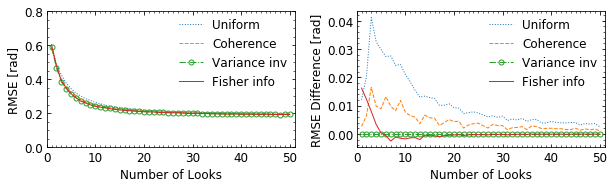

In [81]:
## Figure 1 (e-f) - RMSE of estimated time-series from inversion with different weight functions

# read data
fcontent = np.load('{}.npy'.format(out_file))
xx = fcontent[:, 0].reshape(-1, 1)
rms_inv = fcontent[:, 1:]

# plot
marker_list = [':', '--', '-.o', '-']
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[10, 2.5])
for i in range(len(weight_functions)):
    rms = rms_inv[:, i]
    rms_diff = rms_inv[:, i] - rms_inv[:, -2]
    axs[0].plot(xx, rms,      marker_list[i], lw=1, ms=5, mfc='none', label=weight_functions[i])
    axs[1].plot(xx, rms_diff, marker_list[i], lw=1, ms=5, mfc='none', label=weight_functions[i])

# axis format
axs[0].set_ylim(bottom=0.)
axs[0].set_ylim(top=0.8)
axs[0].set_ylabel('RMSE [rad]', fontsize=font_size)
axs[1].set_ylabel('RMSE Difference [rad]', fontsize=font_size)

for ax in axs:
    ax.set_xlabel('Number of Looks', fontsize=font_size)
    ax.set_xlim((0., np.max(xx)+1))
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
    if out_file == 'rmsVT200R0.0L50':
        ax.legend(loc='best', ncol=1, fontsize=font_size, frameon=False, borderpad=0.1)
fig.subplots_adjust(wspace=0.25)

## Add insert axes
#ax1 = inset_axes(ax, width='50%', height='45%', loc='upper right', borderpad=1.)  ## add insert rectangle
#for i in range(len(weight_functions)):
#    ax1.plot(xx.reshape(-1, 1), rms_inv[:, i], marker_list[i], lw=1, ms=5, mfc='none', label=weight_functions[i])
#ax1.set_xlim(0.8, 4.2)
#daoi = rms_inv[0:4,:]
#ymin1, ymax1 = np.min(daoi), np.max(daoi); ylen = ymax1 - ymin1
#ax1.set_ylim(ymin1-ylen*0.1, ymax1+ylen*0.1)
#ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator(1))
#ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
#ax1.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
#mark_inset(ax, ax1, loc1=2, loc2=3, fc="none", ec="0.5")

# save
plt.savefig('{}.png'.format(out_file), bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

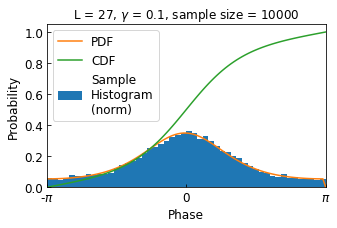

In [3]:
## Figure S2 - Generating Decorrelation Noise by Random Sampling with PDF determined by Coherence
x = psim.sample_decorrelation_phase(3*9, 0.1, size=int(1e4), display=True)

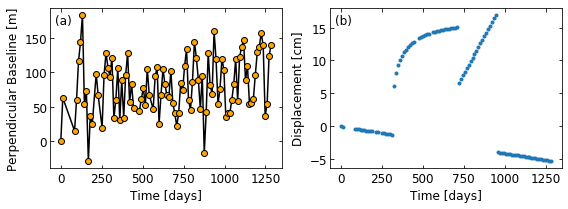

In [60]:
## Figure S3 - Time-series Setup
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[8, 3])

axs[0].plot(tbase, ts_obj.pbase, '-ko', mfc='orange')
axs[0].set_ylabel('Perpendicular Baseline [m]', fontsize=font_size)

axs[1].plot(tbase, ts_sim * 100., '.')
axs[1].set_ylabel('Displacement [cm]', fontsize=font_size)

for ax, num in zip(axs, ['(a)', '(b)']):
    ax.set_xlabel('Time [days]', fontsize=font_size)
    ax.annotate(num, xy=(0.02, 0.9), color='k', xycoords='axes fraction', fontsize=font_size)
    ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
fig.tight_layout()

fig.savefig('timeseries_setup.jpg', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()